# Modeling

In this notebook we implement three differents modeling tools for classification problems: 

   * Logistic Regression
   * Random Forests
   * Artifical Neural Networks (ANN)
    
**Goal** : We want to identify if the phase of a clinial trial will be completed or terminated based on different factors like:

   * Enrollment fraction: (actual number of people enrolled)/(desired number of people)
   * Phase of the trial 
   * Age type of people enrolled in trial phase
   * Genders allowed in trial phase
   * Intervention method of the trial phase
   * Number of months between start and end of phase
   * Actual number of people enrolled
   * Estimated or desired number of people per trial
    
   The goal is to see how well these three different models perform on our data and extract important information.

### Import necessary packages

In [454]:
import pandas as pd
import numpy as np
import seaborn as sns
import unicodedata

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
from matplotlib import pyplot as plt


from dateutil.parser import parse
from datetime import datetime

# Packages for modeling 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# import feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif


## Load and prepare data

We have three different data frames that contain each of our factors as well as classification. The data frames are for clinical trials (obtained from ClinicalTrials.gov) and each data frame consists of 10,000 trials done on respiratory diseases, candiovascular diseases, and cancer. After cleaning and pre-processing the data we have create a final data frame containing all diseases and factors.  

In [455]:
cancer_df= pd.read_pickle('Data/cancer_data_cleaned.pkl')

In [456]:
cardiovascular_df= pd.read_pickle('Data/cardiovascular_data_cleaned.pkl')

In [457]:
respiratory_df= pd.read_pickle('Data/respiratory_data_cleaned.pkl')

In [458]:
data = pd.concat([cancer_df,cardiovascular_df, respiratory_df ])

In [459]:
data.head()

,Rank,Title,Status,Study Results,Conditions,Interventions,Outcome Measures,Gender,Age,Phases,...,Locations,URL,Actual,Estimated,Countries,EFraction,Intervention,Age_Type,Disease,Months
NCT Number,,,,,,,,,,,,,,,,,,,,,
3254875,1,Rehabilitation After Breast Cancer,1,No Results Available,Breast Cancer,Behavioral: Individually tailored nurse naviga...,Distress|Depression|Anxiety|Health related qua...,0.0,"18 Years and older (Adult, Older Adult)",0.0,...,"Rigshospitalet, Copenhagen, Denmark",https://ClinicalTrials.gov/show/NCT03254875,309.0,324.0,[Denmark],0.953704,1,3,cancer,43.0
3736746,2,Testing Feasibility of Motivational Interviewi...,1,No Results Available,Other Cancer,Behavioral: Motivational Interviewing,Feasibility of Motivational Interviewing inter...,2.0,"18 Years and older (Adult, Older Adult)",0.0,...,"Dana Farber Cancer Institute, Boston, Massachu...",https://ClinicalTrials.gov/show/NCT03736746,54.0,54.0,[United States],1.000000,1,3,cancer,9.0
3865654,3,Individualizing Surveillance Mammography for O...,1,No Results Available,Breast Cancer,Other: Communication Tool,Rate of change in intentions for mammography i...,0.0,75 Years and older (Older Adult),0.0,...,"Dana-Farber Cancer Institute, Boston, Massachu...",https://ClinicalTrials.gov/show/NCT03865654,45.0,45.0,[United States],1.000000,10,4,cancer,26.0
2078089,4,Oxcarbazepine Plus Morphine in Patients With R...,0,No Results Available,Cancer,Drug: Morphine|Drug: Oxcarbazepine,Number of patients with adverse events as a me...,2.0,"18 Years and older (Adult, Older Adult)",1.0,...,"Indiana Univeristy Health Hospital, Indianapol...",https://ClinicalTrials.gov/show/NCT02078089,1.0,12.0,[United States],0.083333,0,3,cancer,9.0
3913936,6,"Young, Empowered & Strong (YES): The Young Wom...",1,No Results Available,Breast Cancer,Other: YES portal,Frequency of logging into the portal.|Time spe...,0.0,18 Years to 44 Years (Adult),0.0,...,"Dana Farber Cancer Institute, Boston, Massachu...",https://ClinicalTrials.gov/show/NCT03913936,30.0,30.0,[United States],1.000000,10,2,cancer,4.0


In [460]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24620 entries, 3254875 to 4617015
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   Rank              24620 non-null  int64    
 1   Title             24620 non-null  object   
 2   Status            24620 non-null  int64    
 3   Study Results     24620 non-null  object   
 4   Conditions        24620 non-null  object   
 5   Interventions     24620 non-null  object   
 6   Outcome Measures  24620 non-null  object   
 7   Gender            24620 non-null  float64  
 8   Age               24620 non-null  object   
 9   Phases            24620 non-null  float64  
 10  Enrollment        24620 non-null  float64  
 11  Start Date        24620 non-null  period[M]
 12  Completion Date   24620 non-null  period[M]
 13  Locations         24620 non-null  object   
 14  URL               24620 non-null  object   
 15  Actual            24620 non-null  float64  
 

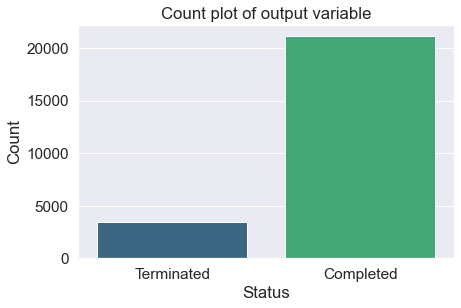

In [461]:
sns.countplot(x = 'Status', data=data, palette="viridis").set(title= "Count plot of output variable")
plt.xticks([0,1],['Terminated','Completed'])
plt.ylabel('Count')
plt.savefig('Images/count_trials.png', bbox_inches='tight')

We can see that the number of trials that were completed far outweighs the number of trials that were terminated. This is important to remember.

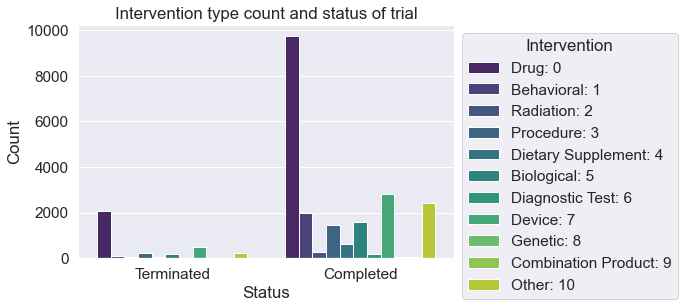

In [462]:
sns.countplot(x='Status', hue='Intervention', data=data, palette="viridis").set(title= "Intervention type count and status of trial")
plt.xticks([0,1],['Terminated','Completed'])
plt.ylabel("Count")
plt.legend(title='Intervention', loc = 2, bbox_to_anchor = (1,1), labels=['Drug: 0', 'Behavioral: 1', 'Radiation: 2', 'Procedure: 3', 'Dietary Supplement: 4',
                     'Biological: 5', 'Diagnostic Test: 6', 'Device: 7 ','Genetic: 8', 'Combination Product: 9',
                     'Other: 10'])
plt.savefig('Images/intervention_type_count.png', bbox_inches='tight')

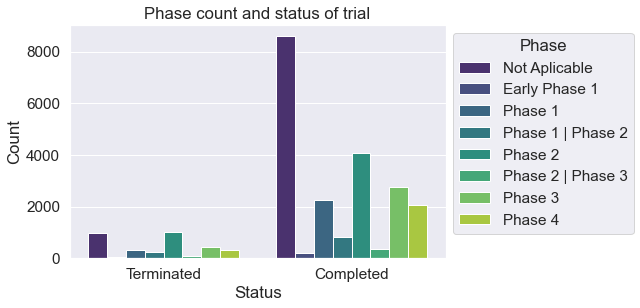

In [463]:
sns.countplot(x='Status', hue='Phases', data=data, palette="viridis").set(title= "Phase count and status of trial")
plt.xticks([0,1],['Terminated','Completed'])
plt.ylabel("Count")
plt.legend(title='Phase', loc = 2, bbox_to_anchor = (1,1), labels=['Not Aplicable', 'Early Phase 1', 'Phase 1', 'Phase 1 | Phase 2',
                                                                  'Phase 2', 'Phase 2 | Phase 3', 'Phase 3', 'Phase 4'])
plt.savefig('Images/phase_type_count.png', bbox_inches='tight')

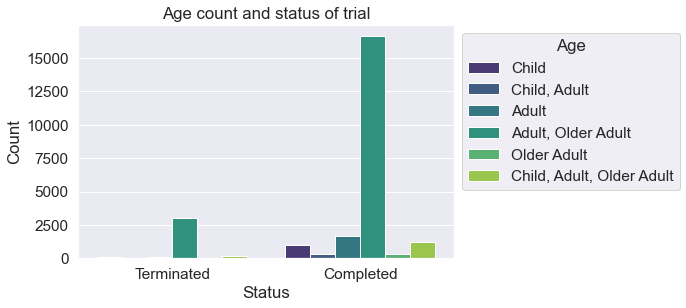

In [464]:
sns.countplot(x='Status', hue='Age_Type', data=data, palette="viridis").set(title= "Age count and status of trial")
plt.xticks([0,1],['Terminated','Completed'])
plt.ylabel("Count")
plt.legend(title='Age', loc = 2, bbox_to_anchor = (1,1), labels=['Child', 'Child, Adult', 'Adult',
                                                                 'Adult, Older Adult', 'Older Adult', 
                                                                 'Child, Adult, Older Adult'])
plt.savefig('Images/age_type_count.png', bbox_inches='tight')

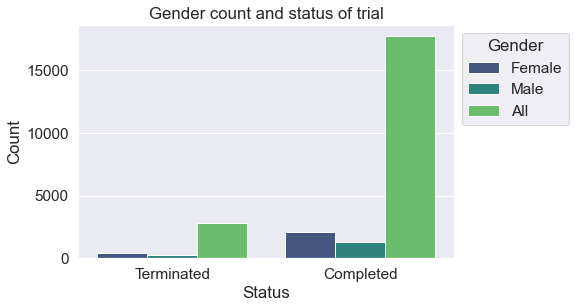

In [465]:
sns.countplot(x='Status', hue='Gender', data=data, palette='viridis').set(title= "Gender count and status of trial")
plt.xticks([0,1],['Terminated','Completed'])
plt.ylabel("Count")
plt.legend(title='Gender', loc = 2, bbox_to_anchor = (1,1), labels=['Female', 'Male', 'All'])
plt.savefig('Images/gender_type_count.png')

In [466]:
corrMatrix= data[['Status','EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated']].corr()

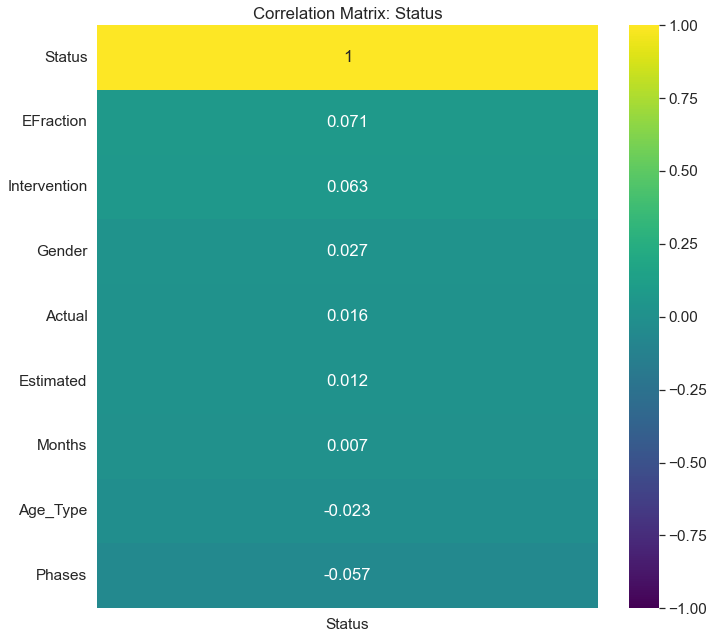

In [467]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

sns.heatmap(corrMatrix[['Status']].sort_values(by='Status', ascending=False), vmin=-1,
            vmax=1, annot=True, cmap='viridis').set(title= "Correlation Matrix: Status")

#sns.heatmap(corrMatrix, annot=True, cmap='viridis').set(title= "Correlation Matrix")
plt.savefig('Images/corrMatrix.png', bbox_inches='tight')
plt.show()

## Logistic Regression Models

The first model we will implement is logistic regression. This is the classic way to perform binary classification. In simple terms, it's a generalized model that predicts the probability that an event will occur. Specifically, Logistic Regression uses regular linear regression to model the `logit` function. 

### 1. Model Built Using Single Feature = EFraction

In [468]:
# Split into input and output data
# adjust data into array
X = data['EFraction'].to_numpy()
y = data['Status'].to_numpy()

In [469]:
# Check model data
X, y

(array([0.9537037 , 1.        , 1.        , ..., 1.        , 0.02631579,
        1.        ]),
 array([1, 1, 1, ..., 1, 0, 1]))

In [470]:
# make a stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=1,
                                                       test_size=.33,
                                                       stratify=y)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (16495,) (16495,)
Test (8125,) (8125,)


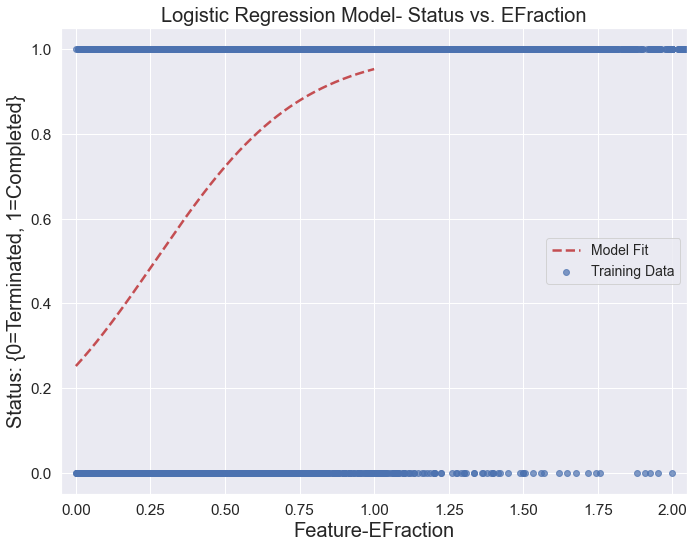

<Figure size 432x288 with 0 Axes>

In [471]:
## make model object
log_reg = LogisticRegression()

## fit the model
log_reg.fit(X_train.reshape(-1,1), y_train)


# Plot figure 
plt.figure(figsize = (10,8))

# With classifications we have a new method
# predict_proba which returns the probability
# that an observation is a certain class.
plt.plot(np.linspace(0,1,1000),
            log_reg.predict_proba(np.linspace(0,1,1000).reshape(-1,1))[:,1],
            'r--',linewidth=2.5,label = "Model Fit")
plt.scatter(X_train,y_train,label = 'Training Data',alpha=.7)
plt.legend(fontsize = 14,loc = 'best')
plt.xlabel("Feature-EFraction",fontsize = 20)
plt.ylabel("Status: {0=Terminated, 1=Completed}",fontsize=20) 
plt.xlim([-0.05,2.05])
plt.title('Logistic Regression Model- Status vs. EFraction', fontsize=20)

plt.show()

## save fig
plt.savefig("Images/Logistic_Regression_EF.png", dpi=200, bbox_inches='tight')

In [472]:
print('The importance of EFraction for the single feature logistic regression model is %.4f' % (log_reg.coef_[0]))

The importance of EFraction for the single feature logistic regression model is 4.0858


#### Model Evaluation

In [473]:
predictions_efraction= log_reg.predict(X_test.reshape(-1,1))
print(classification_report(y_test, predictions_efraction))

              precision    recall  f1-score   support

           0       0.68      0.45      0.54      1145
           1       0.91      0.97      0.94      6980

    accuracy                           0.89      8125
   macro avg       0.80      0.71      0.74      8125
weighted avg       0.88      0.89      0.88      8125



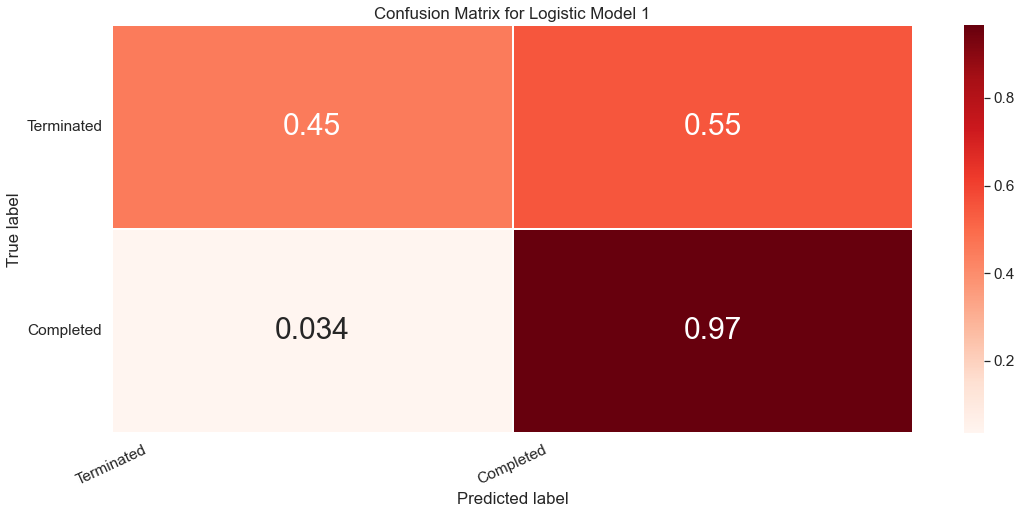

In [474]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predictions_efraction)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':30},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Terminated', 'Completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Model 1')
plt.savefig('Images/CM_Logistic1.png', bbox_inches='tight')
plt.show()


### 2. Model Built Using All Features Of Interest (Numerical Representation)

#### Train, Test, Split

In [475]:
X= data[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated' ]]

In [476]:
y=data['Status']

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [478]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (16495, 8) (16495,)
Test (8125, 8) (8125,)


#### Building the Model

In [479]:
logmodel= LogisticRegression(class_weight='balanced')
logmodel.fit(X_train, y_train)
predictions_log= logmodel.predict(X_test)

#### Model Evaluation

We can evaluate the model's performance on our testing dataset using a Confusion Matrix and looking at the model in terms of Recall, Precision, Sensitivity (f1-score), and Support.

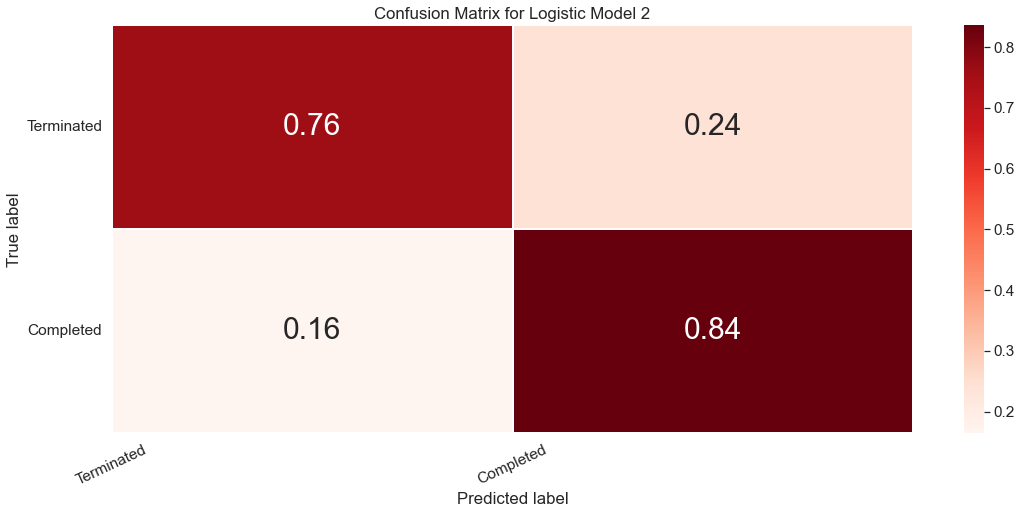

In [480]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predictions_log)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':30},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Terminated', 'Completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Model 2')
plt.savefig('Images/CM_Logistic2.png', bbox_inches='tight')
plt.show()

In [481]:
print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

           0       0.43      0.76      0.55      1133
           1       0.96      0.84      0.89      6992

    accuracy                           0.83      8125
   macro avg       0.69      0.80      0.72      8125
weighted avg       0.88      0.83      0.84      8125



This model has an accuracy score of 83% on the test data. This seems pretty impressive, but remember that accuracy is not a great measure of classifier performance when the classes are imbalanced. We can see that our model has a 96% precision rate for trial completion and a 43% precision rate for termination. This is no doubt a result of our data imbalance. 

#### Feature Importance 

To better understand the performance of our model, we can investigate each individual feature. Scores marked with a zero coefficient, or very near zero coefficient, indicate that the model found those features unimportant and essentially removed them from the model. Positive scores indicate a feature that predicts class 1 (Completed). Negative scores indicate a feature that predicts class 2 (Terminated).

In [482]:
importance= logmodel.coef_.flatten()
importance

array([12.2967511 ,  0.10634385, -0.08759329, -0.05374497,  0.02685446,
       -0.19837488, -1.36370864,  2.14141032])

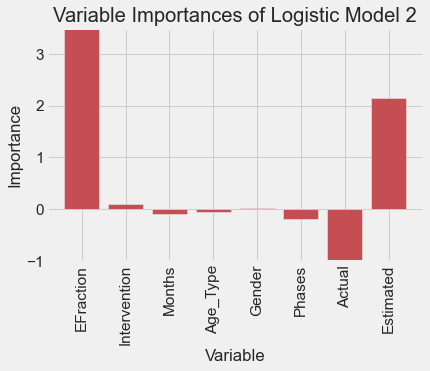

In [483]:
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importance)))
# Make a bar chart
plt.bar(x_values, importance, orientation = 'vertical', color="r")
# Tick labels for x axis
plt.xticks(x_values,list(X.columns) , rotation='vertical')
plt.ylim(-1, 3.5)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances of Logistic Model 2');
plt.savefig('Images/Importances_Logistic2.png', bbox_inches='tight')

We can see that the enrollment fraction is very important for predicting completion of a trial. Months, age type, phases, gender, intervention have been marked as unimportant by the model.

### 3. Model Built Using Chi-Squared Features

Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.
The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

#### Train, Test, Split


In [484]:
# Split into input and output data
# adjust data into array
X = data.copy()
X = data.filter(['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated'], axis=1).to_numpy()
y = data['Status'].to_numpy()

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=1,
                                                       test_size=.33,
                                                       stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Building the model

In [486]:
# feature selection
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [487]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train)

# evaluate the model
yhat = model.predict(X_test_fs)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy of Chi-Squared Features: %.4f' % (accuracy*100))

Accuracy of Chi-Squared Features: 85.9077


#### Model Evaluation

In [488]:
predictions_chi= model.predict(X_test_fs)
print(classification_report(yhat, predictions_chi))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8125

    accuracy                           1.00      8125
   macro avg       1.00      1.00      1.00      8125
weighted avg       1.00      1.00      1.00      8125



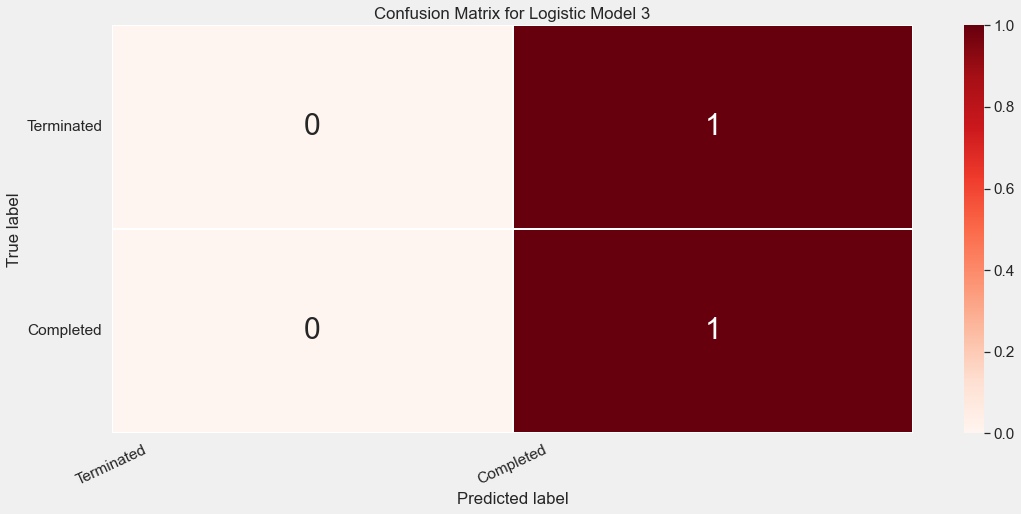

In [489]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predictions_chi)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':30},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Terminated', 'Completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Model 3')
plt.savefig('Images/CM_Logistic3.png', bbox_inches='tight')
plt.show()

#### Feature Importance

In [490]:
X_columns = list(data[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated']].columns)
# Get numerical feature importances
importances = list(fs.scores_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Intervention         Importance: 24.48
Variable: Phases               Importance: 15.97
Variable: EFraction            Importance: 2.69
Variable: Gender               Importance: 1.68
Variable: Actual               Importance: 1.12
Variable: Estimated            Importance: 0.74
Variable: Age_Type             Importance: 0.45
Variable: Months               Importance: 0.06


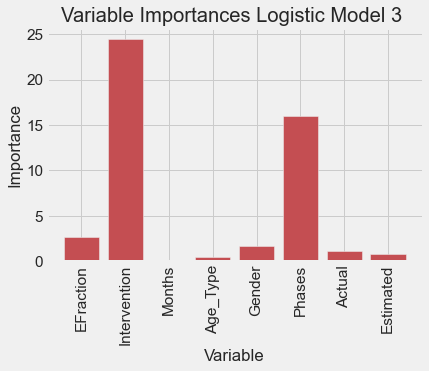

In [491]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color="r")
# Tick labels for x axis
plt.xticks(x_values,X_columns , rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances Logistic Model 3 ');
plt.savefig('Images/Importances_Logistic3.png', bbox_inches='tight')

### 4. Model Built Using Mutual Information Features

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

#### Train, Test, Split

In [492]:
# Split into input and output data
# adjust data into array
X = data.copy()
X = data.filter(['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated'], axis=1).to_numpy()
# add X data: Countries and Month
y = data['Status'].to_numpy()

In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=1,
                                                       test_size=.33,
                                                       stratify=y)

#### Building the Model

In [494]:
# feature selection function
fs_m = SelectKBest(score_func=mutual_info_classif, k=2)
fs_m.fit(X_train, y_train)
X_train_fs_m = fs_m.transform(X_train)
X_test_fs_m = fs_m.transform(X_test)

In [495]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs_m, y_train)

# evaluate the model
yhat = model.predict(X_test_fs_m)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy of Mutual Features: %.4f' % (accuracy*100))

Accuracy of Mutual Features: 89.3292


#### Model Evaluation

In [496]:
predictions_mutual= model.predict(X_test_fs_m)
print(classification_report(yhat, predictions_mutual))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       758
           1       1.00      1.00      1.00      7367

    accuracy                           1.00      8125
   macro avg       1.00      1.00      1.00      8125
weighted avg       1.00      1.00      1.00      8125



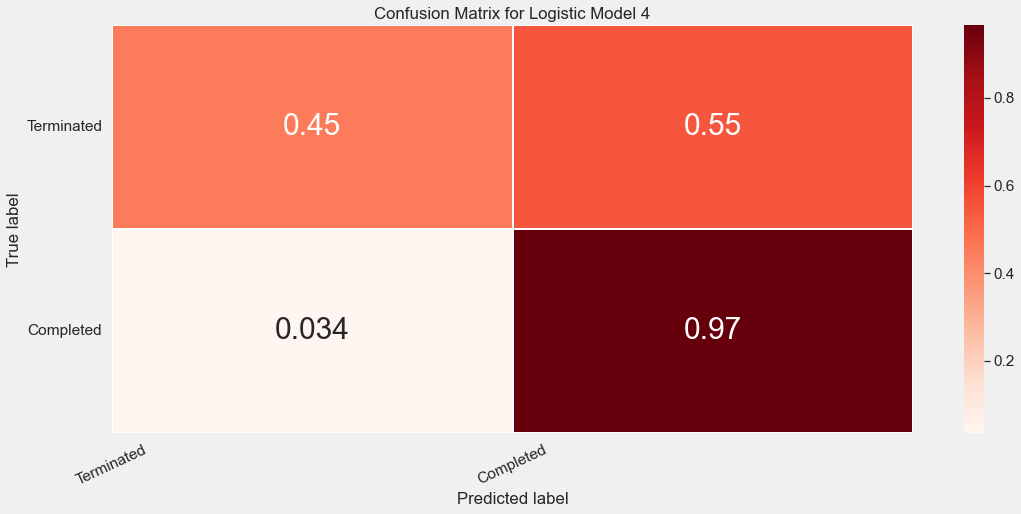

In [497]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predictions_mutual)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':30},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Terminated', 'Completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Model 4')
plt.savefig('Images/CM_Logistic4.png', bbox_inches='tight')
plt.show()

In [498]:
X_columns = list(data[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated']].columns)
# Get numerical feature importances
importances = list(fs_m.scores_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: EFraction            Importance: 0.13
Variable: Actual               Importance: 0.07
Variable: Intervention         Importance: 0.01
Variable: Age_Type             Importance: 0.01
Variable: Months               Importance: 0.0
Variable: Gender               Importance: 0.0
Variable: Phases               Importance: 0.0
Variable: Estimated            Importance: 0.0


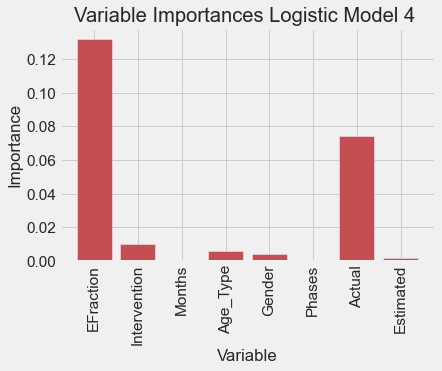

In [499]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color="r")
# Tick labels for x axis
plt.xticks(x_values,X_columns , rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances Logistic Model 4 ');
plt.savefig('Images/Importances_Logistic4.png', bbox_inches='tight')

# Random Forest 

Random Forest is also a powerful tool for classification problems. 

### Train, Test, Split

In [500]:
X= data[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' , 'Phases', 'Actual', 'Estimated' ]]
y= data['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### Building the Model

In [501]:
random_forest = RandomForestClassifier(n_estimators=6, random_state=0, max_depth=5)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=6, random_state=0)

In [502]:
# Use the forest's predict method on the test data
y_pred_list = random_forest.predict(X_test) 

# Calculate the absolute errors
errors = abs(y_pred_list - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.1 degrees.


In [503]:
# Pull out one tree from the forest
tree = random_forest.estimators_[5]

In [504]:
export_graphviz(tree, out_file = 'tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

In [505]:
# Write graph to a png file
graph.write_png('Images/Random_Forest.png')

### Model Evaluation 

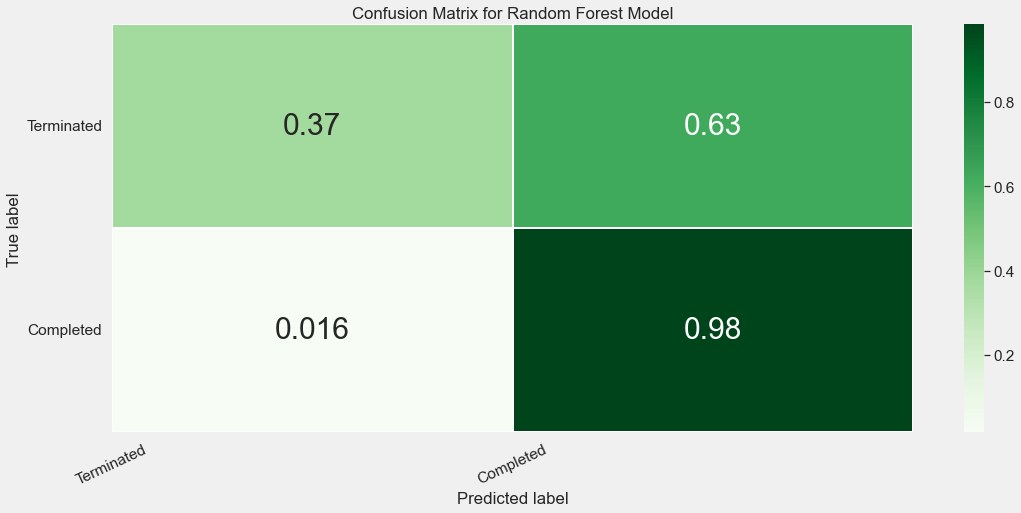

In [506]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_list)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':30},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Terminated', 'Completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.savefig('Images/CM_RandomForest.png', bbox_inches='tight')
plt.show()

In [507]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.79      0.37      0.51      1133
           1       0.91      0.98      0.94      6992

    accuracy                           0.90      8125
   macro avg       0.85      0.68      0.73      8125
weighted avg       0.89      0.90      0.88      8125



This model has an accuracy score of 90% on the test data, which is slightly better than the Logistic Model. While the completed trials are very well predicted (we can see this from the precision, recall, and f1-score), it's not as good for the terminated trials with very low overall metrics. 

### Feature Importance

In [508]:
# Get numerical feature importances
importances = list(random_forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: EFraction            Importance: 0.55
Variable: Actual               Importance: 0.35
Variable: Phases               Importance: 0.03
Variable: Estimated            Importance: 0.03
Variable: Intervention         Importance: 0.01
Variable: Months               Importance: 0.01
Variable: Age_Type             Importance: 0.01
Variable: Gender               Importance: 0.0


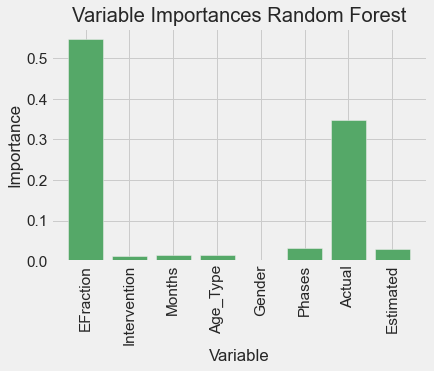

In [509]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color="g")
# Tick labels for x axis
plt.xticks(x_values,list(X.columns) , rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances Random Forest');
plt.savefig('Images/Importances_RandomForest.png', bbox_inches='tight')

We can see that the enrollment fraction is still very important for predicting completion of a trial. The random forest also considers the actual value of enrolled people as an important feature.

# ANN

In this section we build a classification neural network.  

### Data Preparation

In [434]:
X= data[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender', 'Phases' ]].values
y= data['Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

### Feature Scaling

In [435]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Parameters

In [436]:
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

### Dataset and DataLoader

In [437]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [438]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

### Neural Network Architecture

In [439]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(6, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [440]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Optimizer and Loss function

In [441]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=6, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train Model 

In [442]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [443]:
model.train()
losses = []
accur = []

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        
    if e%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


        

    

Epoch 050: | Loss: 0.28807 | Acc: 89.275
Epoch 100: | Loss: 0.28150 | Acc: 89.105
Epoch 150: | Loss: 0.27566 | Acc: 89.453
Epoch 200: | Loss: 0.27532 | Acc: 89.550
Epoch 250: | Loss: 0.27557 | Acc: 89.628
Epoch 300: | Loss: 0.27263 | Acc: 89.783
Epoch 350: | Loss: 0.27317 | Acc: 89.612
Epoch 400: | Loss: 0.27185 | Acc: 89.822
Epoch 450: | Loss: 0.27231 | Acc: 89.473
Epoch 500: | Loss: 0.27092 | Acc: 89.678
Epoch 550: | Loss: 0.27105 | Acc: 89.674
Epoch 600: | Loss: 0.26842 | Acc: 89.791
Epoch 650: | Loss: 0.26864 | Acc: 89.888
Epoch 700: | Loss: 0.26902 | Acc: 89.880
Epoch 750: | Loss: 0.26912 | Acc: 89.872
Epoch 800: | Loss: 0.26913 | Acc: 89.775
Epoch 850: | Loss: 0.26893 | Acc: 89.814
Epoch 900: | Loss: 0.26770 | Acc: 89.744
Epoch 950: | Loss: 0.26618 | Acc: 90.023
Epoch 1000: | Loss: 0.26884 | Acc: 89.826


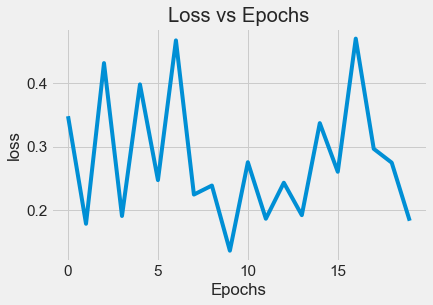

In [444]:
plt.plot(torch.stack(losses).cpu().detach().numpy())
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.savefig('Images/Loss_ANN.png', bbox_inches='tight')

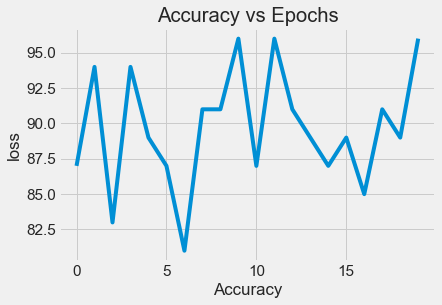

In [445]:
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')
plt.savefig('Images/Accuracy_ANN.png', bbox_inches='tight')

### Test the model

In [446]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Model Evaluation

In [447]:
matrix= confusion_matrix(y_test, y_pred_list)

In [448]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.70      0.47      0.56      1141
           1       0.92      0.97      0.94      6984

    accuracy                           0.90      8125
   macro avg       0.81      0.72      0.75      8125
weighted avg       0.89      0.90      0.89      8125



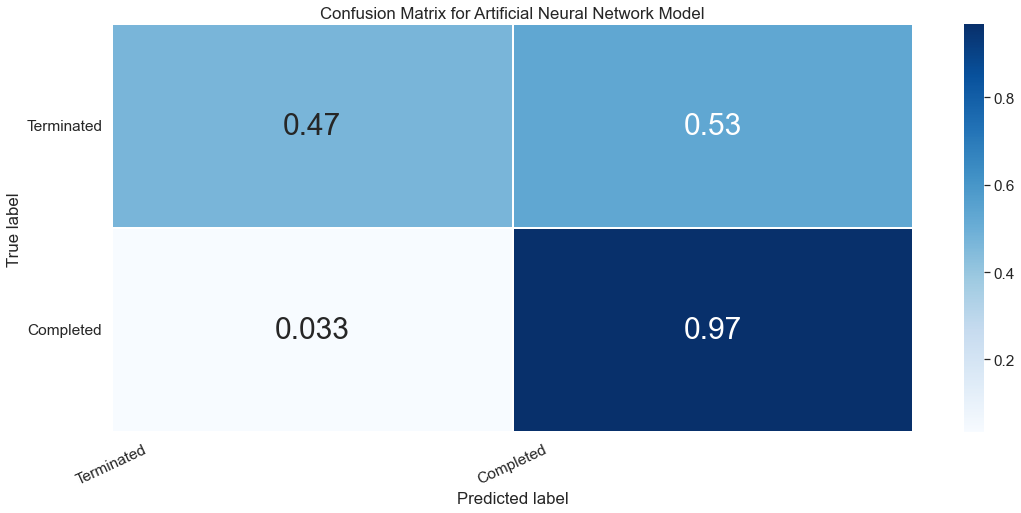

In [453]:
# Get and reshape confusion matrix data
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':30},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Terminated', 'Completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Artificial Neural Network Model')
plt.savefig('Images/CM_ANN.png', bbox_inches='tight')
plt.show()

This model has an accuracy score of 90% on the test data, which is very close to the Random Forest model. We do see an increase for both terminated and completed trials, it has a 91% precision rate for trial completion and a 74% precision rate for termination. But this model is still not good enough if we look at the recall and f1-score for the terminated trials. 